### Building a Topic Classifier using Azure OpenAI GPT

### Problem description
    The task at hand involves constructing a topic classifier to categorize user questions into different topics. This classifier serves as a precursor in the workflow, preceding several ChatGPT chatbots, each addressing questions on specific topics.
    
### Background
    The chatbot is intended for use by Whitley Newman, an insurance company offering a range of services, including auto, property, life, and policy operations. The classifier is designed to sort user queries into 11 distinct topics:

    The six topics are:       
        1 'auto insurance premium',
        2 'billing and payments',
        3 'claims processing',
        4 'continued conversation',
        5 'coverage options',
        6 'end conversation',
        7 'irrelevant of insurance',
        8 'property insurance'

### Data
    The dataset used for training the topic classifier is synthetically generated through multiple GPT API calls. It comprises 145 question and answers, covering the eight topics mentioned above. Each row contains a single exchange of questions and answers between a customer and an agent, with the topic labeled accordingly.

### Evaluation Metrics
    The topic classifier demonstrates satisfactory performance on the synthetic dataset, with evaluation metrics reported as follows:
    Weighted accuracy, precision, and the recall using GPT 3.5.

### Deployment Considerations:
    While the classifier performs good enought on real and synthetic data, it's essential to evaluate its performance on real-world business classification problems. Deployment decisions should factor in both model performance and cost considerations, selecting the best model for operational use based on these factors



# set up

In [41]:
#pip install -r requirements.txt
import json
import jsonlines
import logging
logging.basicConfig(filename='ctc.log', encoding='utf-8', level=logging.DEBUG)
logger = logging.getLogger('ftpuploader')
import numpy as np
import matplotlib.pyplot as plt
import os
from openai import AzureOpenAI
import pandas as pd
import re
import seaborn as sns
import sys
import time
import yaml

from datetime import date, datetime
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [42]:
# Load config values
with open(r'config.json') as config_file:
    config_details = json.load(config_file)

#chatgpt_model_name = config_details['CHATGPT_MODEL']
#openai.api_type = "azure"
#openai.api_key = config_details['OPENAI_API_KEY']
#openai.api_base = config_details['OPENAI_API_BASE']
#openai.api_version = config_details['OPENAI_API_VERSION']

# loading the data

In [43]:
#dataset COLLECTED
df_raw = pd.read_csv("synthetic_data_topic_classifier.csv")

In [44]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   QnA                145 non-null    object
 1   topic              145 non-null    object
 2   customer_question  68 non-null     object
 3   agent_reply        145 non-null    object
dtypes: object(4)
memory usage: 4.7+ KB


In [45]:
df_raw.sample()

,QnA,topic,customer_question,agent_reply
127,Is there coverage available for damage caused by sewer backups or sump pump failures?,coverage options,NaN,"Yes, coverage for damage from sewer backups or sump pump failures may be available as an endorsement or separate policy; contact us to discuss your coverage needs."


# Cleaning data and EDA

In [46]:
#Read all topics for easy reading and creating map
set_topics = set()

for grouped_types in df_raw.topic.unique():
    for ea_type in grouped_types.split(','):
        set_topics.add(ea_type.strip(" ''[]"))

set_topics

{'auto insurance premium',
 'billing and payments',
 'claims processing',
 'continued conversation',
 'coverage options',
 'end conversation',
 'irrelevant of insurance',
 'property insurance'}

In [47]:
# creating a map with each topic name strings base on the gathered dataset
map_t_n =  {'auto insurance premium': 1,
         'billing and payments': 2,
         'claims processing': 3,
         'continued conversation': 4,
         'coverage options': 5,
         'end conversation': 6,
         'irrelevant of insurance': 7,
         'property insurance': 8}

In [48]:
df_raw['choice'] = df_raw.topic.apply(lambda x: map_t_n[x])

In [49]:
df_raw['completion'] = df_raw.choice.apply(lambda x: ' ' + str(x) + ' END')

In [50]:
df_raw.head()

,QnA,topic,customer_question,agent_reply,choice,completion
0,"How are auto insurance premiums calculated?\nAuto insurance premiums are calculated based on a variety of factors, including the make and model of your car, your driving record, and the amount of coverage you choose.",auto insurance premium,How are auto insurance premiums calculated?,"Auto insurance premiums are calculated based on a variety of factors, including the make and model of your car, your driving record, and the amount of coverage you choose.",1,1 END
1,"How can I save money on my auto insurance premiums?\nThere are a number of ways to save money on your auto insurance premiums, including raising your deductible, choosing a higher coverage limit, and bundling your auto insurance with other policies.",auto insurance premium,How can I save money on my auto insurance premiums?,"There are a number of ways to save money on your auto insurance premiums, including raising your deductible, choosing a higher coverage limit, and bundling your auto insurance with other policies.",1,1 END
2,"How do I know if I need to purchase auto insurance?\nIf you drive a car in the United States, you are required by law to have auto insurance.",auto insurance premium,How do I know if I need to purchase auto insurance?,"If you drive a car in the United States, you are required by law to have auto insurance.",1,1 END
3,"What factors affect my auto insurance premiums?\nThe make and model of your car, your driving record, and the amount of coverage you choose all affect your auto insurance premiums.",auto insurance premium,What factors affect my auto insurance premiums?,"The make and model of your car, your driving record, and the amount of coverage you choose all affect your auto insurance premiums.",1,1 END
4,"What is the minimum amount of auto insurance coverage I am required to have?\nThe minimum amount of auto insurance coverage you are required to have varies by state, but is typically between $25,000 and $50,000 per person and $50,000 and $100,000 per accident.",auto insurance premium,What is the minimum amount of auto insurance coverage I am required to have?,"The minimum amount of auto insurance coverage you are required to have varies by state, but is typically between $25,000 and $50,000 per person and $50,000 and $100,000 per accident.",1,1 END


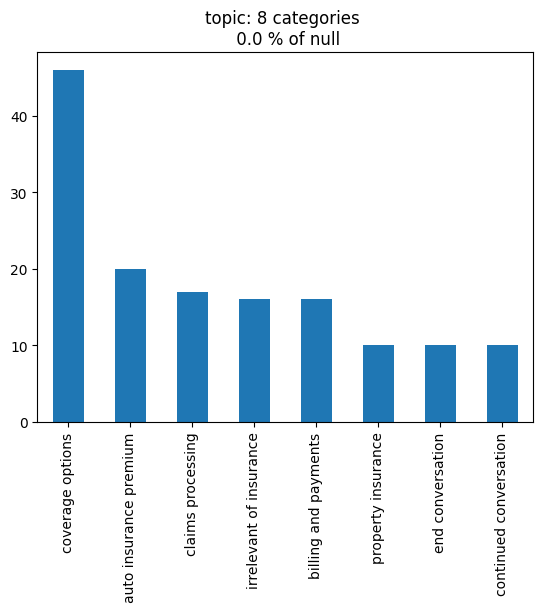

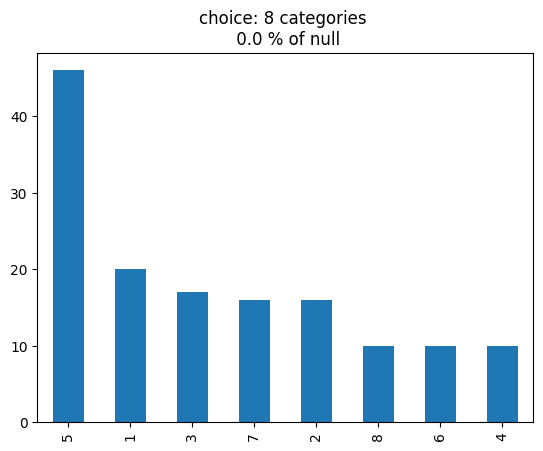

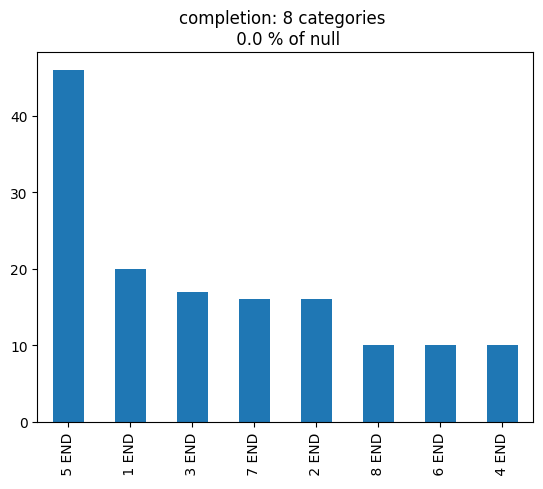

In [51]:
for col in df_raw.columns:
    if col in ['QnA', 'customer_question', 'agent_reply'] or df_raw[col].isnull().all():
        continue
    plt.figure()
    df_raw[col].value_counts().plot.bar()
    pct_null = np.round(df_raw[col].isnull().sum() / df_raw.shape[0] * 100, 1)
    plt.title(f'{col}: {df_raw[col].astype(str).transform(tuple).nunique()} categories \n {pct_null} % of null')

# pre-processing

In [52]:
def pre_processing(df, prompt_content, output_path, tag_few_shot=False):
    '''
    Recreating the prompt or question base on the topic to ask to the MODEL 
    Then save as json pre-processed 
    '''

    df_raw = df.copy()
    df_raw['prompt_original'] = df_raw.customer_question
    
    if tag_few_shot:
        df_raw['prompt'] = (prompt_content + 'Customer question: '+ df_raw.customer_question +'\nClassified topic: '
                           )
    else:
        df_raw['prompt'] = (f"Insurer's question:\n" + df_raw.customer_question
                    + '\n' + prompt_content)

    df_sample = df_raw.copy()
    df_sample.to_csv(f'{output_path}.csv')
    
    save_path = f'{output_path}.jsonl'
    df_sample.to_json(save_path, orient='records', lines=True)
    
    print(df_sample.info())
    print(f'data saved at {save_path}')
    print('----show a sample prompt for check----')
    print(df_sample.prompt.iloc[0])
    
    return df_sample, save_path

In [53]:
for pair in map_t_n.items():
    print(f"{pair[1]} '{pair[0]}'")


1 'auto insurance premium'
2 'billing and payments'
3 'claims processing'
4 'continued conversation'
5 'coverage options'
6 'end conversation'
7 'irrelevant of insurance'
8 'property insurance'


# batch prediction


In [54]:
def stage_examples_for_prediction(input_json_address):
    '''Preparing the test data for inferencing'''
    example_list = []
    with jsonlines.open(input_json_address) as reader:
        for obj in reader:
            example_list.append(obj)
    return example_list

In [62]:
prompt_zero_shot = '''

Based on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 11.
Make choices based on provided facts, don't imply nor make up stuff.

Detailed Guidelines for how to choose:
    choose 1 if the question is about auto insurance premium.
    choose 2 if the question is about billing and payments.
    choose 3 if the question is about claims processing.
    choose 4 if the question is just a continuation of previous question.
    choose 5 if the question is about coverage options.
    choose 6 if the question is just the end conversation.
    choose 7 if the question is irrelevant of insurance.
    choose 8 if the question is about property insurance.    
Choose one correct number: 
'''

In [63]:
df, file_path_zero_shot = pre_processing(df_raw, prompt_zero_shot, output_path='prompt_zero_shot')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   QnA                145 non-null    object
 1   topic              145 non-null    object
 2   customer_question  68 non-null     object
 3   agent_reply        145 non-null    object
 4   choice             145 non-null    int64 
 5   completion         145 non-null    object
 6   prompt_original    68 non-null     object
 7   prompt             68 non-null     object
dtypes: int64(1), object(7)
memory usage: 9.2+ KB
None
data saved at prompt_zero_shot.jsonl
----show a sample prompt for visual check----
Insurer's question:
How are auto insurance premiums calculated?


Based on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 11.
Make choices based on provided facts, don't imply nor make up stuff.

Detailed Guide

In [64]:
import random
classifier_model = 'gpt-35-turbo-16k' # model = "WNChatbotDevelopment" text-embedding-3-large text-embedding-ada-002 gpt-35-turbo gpt-35-turbo-instruct
classifier_path = file_path_zero_shot
print(classifier_model, classifier_path)

MODEL_NAME=classifier_model
data_path = classifier_path
col_interest='completion'

input_json_address = data_path

example_list = []
example_list_C = []
example_list_Class = []

#with jsonlines.open(input_json_address) as reader:
#    for obj in reader:
#        example_list.append(obj['prompt'])
#        example_list_C.append(obj['choice'])
#        example_list_Class.append(obj['topic'])

#Load the data from the JSON file
with jsonlines.open(input_json_address) as reader:
    data = list(reader)  # Convert the reader to a list

#Shuffle the data to randomize the order
random.shuffle(data)

#Select the first 20 examples
for obj in data[:20]:
    example_list.append(obj['prompt'])
    example_list_C.append(obj['choice'])
    example_list_Class.append(obj['topic'])
    


with open(r'config.json') as config_file:
    config_details = json.load(config_file)

classifier_model = config_details['CHATGPT_MODEL']
        
        
client = AzureOpenAI(
  azure_endpoint = config_details['OPENAI_API_BASE'], 
  api_key=config_details['OPENAI_API_KEY'],  
  api_version=config_details['OPENAI_API_VERSION']
)

response_list = []

for item in example_list:
    try:    
        messages = []
        #messages.append({"role": "user", "content": example_list[1]})
        messages.append({"role": "user", "content": item})

        response = client.chat.completions.create(
          model=classifier_model, # model = "WNChatbotDevelopment" text-embedding-3-large text-embedding-ada-002 gpt-35-turbo gpt-35-turbo-instruct
          messages = messages,
          temperature=0,
          max_tokens=800,
          top_p=0.95,
          frequency_penalty=0.0,
          presence_penalty=0.0,
          stop='END',
        )

        content = response.choices[0].message.content
        response_list.append(content)
        print(len(response_list))
    except BaseException as e:
        logger.exception('failure when calling API')
        response_list.append(0) 
    
y_pred = response_list  

df_evaluate = pd.DataFrame()
df_evaluate['prompt'] = example_list
df_evaluate['pred'] = y_pred
df_evaluate['completion'] = example_list_C
df_evaluate['Class'] = example_list_Class

             
df_evaluate.head()


gpt-35-turbo-16k prompt_zero_shot.jsonl
1
2
3
5
7
11
12
19
20


,prompt,pred,completion,Class
0,"Insurer's question:\nCustomer: how can I reniew the policy again.\n\n\nBased on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 11.\nMake choices based on provided facts, don't imply nor make up stuff.\n\nDetailed Guidelines for how to choose:\n choose 1 if the question is about auto insurance premium.\n choose 2 if the question is about billing and payments.\n choose 3 if the question is about claims processing.\n choose 4 if the question is just a continuation of previous question.\n choose 5 if the question is about coverage options.\n choose 6 if the question is just the end conversation.\n choose 7 if the question is irrelevant of insurance.\n choose 8 if the question is about property insurance. \nChoose one correct number: \n",4,5,coverage options
1,"Insurer's question:\nCustomer: ""I'm so relieved that I was able to get my insurance issue resolved. Thanks for your help.""\n\n\nBased on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 11.\nMake choices based on provided facts, don't imply nor make up stuff.\n\nDetailed Guidelines for how to choose:\n choose 1 if the question is about auto insurance premium.\n choose 2 if the question is about billing and payments.\n choose 3 if the question is about claims processing.\n choose 4 if the question is just a continuation of previous question.\n choose 5 if the question is about coverage options.\n choose 6 if the question is just the end conversation.\n choose 7 if the question is irrelevant of insurance.\n choose 8 if the question is about property insurance. \nChoose one correct number: \n",6,6,end conversation
2,"Insurer's question:\nCustomer: What else can you tell me?\n\n\nBased on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 11.\nMake choices based on provided facts, don't imply nor make up stuff.\n\nDetailed Guidelines for how to choose:\n choose 1 if the question is about auto insurance premium.\n choose 2 if the question is about billing and payments.\n choose 3 if the question is about claims processing.\n choose 4 if the question is just a continuation of previous question.\n choose 5 if the question is about coverage options.\n choose 6 if the question is just the end conversation.\n choose 7 if the question is irrelevant of insurance.\n choose 8 if the question is about property insurance. \nChoose one correct number: \n",4,4,continued conversation
3,None,0,3,claims processing
4,"Insurer's question:\nWhat is the best way to save money on auto insurance premiums?\n\n\nBased on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 11.\nMake choices based on provided facts, don't imply nor make up stuff.\n\nDetailed Guidelines for how to choose:\n choose 1 if the question is about auto insurance premium.\n choose 2 if the question is about billing and payments.\n choose 3 if the question is about claims processing.\n choose 4 if the question is just a continuation of previous question.\n choose 5 if the question is about coverage options.\n choose 6 if the question is just the end conversation.\n choose 7 if the question is irrelevant of insurance.\n choose 8 if the question is about property insurance. \nChoose one correct number: \n",1,1,auto insurance premium


# metric

### confusion matrix

In [65]:
def eval_classification(df, col_GT, col_pred):
    '''
    display classificatione evaluation metrics and confusion matrix
    '''
    df = df.copy()
    y_true = df[col_GT].astype(str)
    y_pred = df[col_pred].astype(str)
    labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    # display(cf_matrix)
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                        display_labels=labels
                                       )
    
    cm_display.plot(ax=ax, xticks_rotation='vertical')
    print(classification_report(y_true, y_pred, zero_division=1))
    
    return None

# result display

auto insurance premium     4
billing and payments       1
claims processing          3
continued conversation     1
coverage options           8
end conversation           1
irrelevant of insurance    1
property insurance         1
Name: pred_class, dtype: int64

1    4
2    1
3    3
4    1
5    8
6    1
7    1
8    1
Name: ground_truth, dtype: int64

Text(0.5, 1.0, 'ground_truth, number of classes 8')

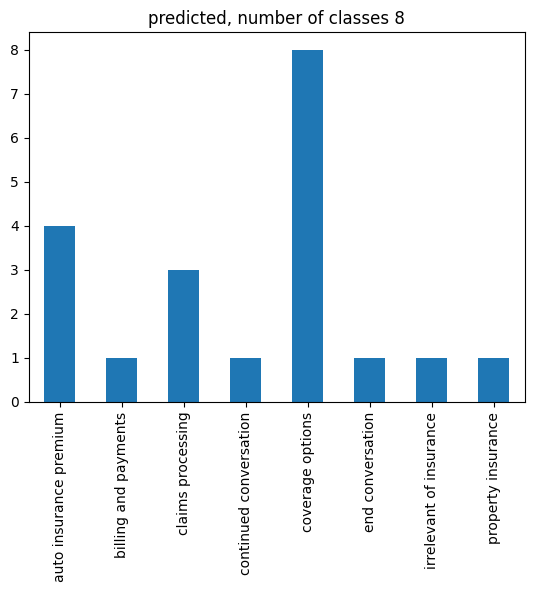

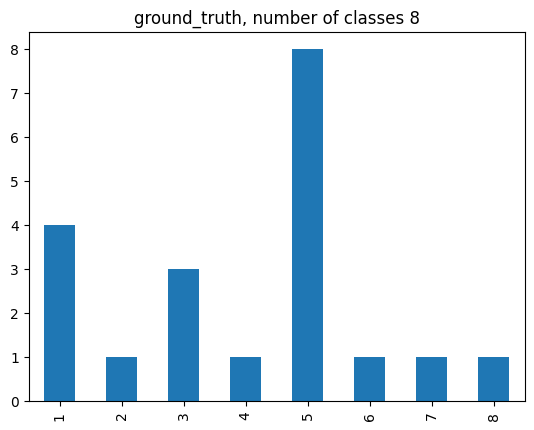

In [66]:
#post processing and evaluation.

df_evaluate_reasons = pd.DataFrame()

df_evaluate_reasons['ground_truth'] = df_evaluate['completion']
df_evaluate_reasons['pred'] = df_evaluate['pred']
df_evaluate_reasons['pred_class'] = df_evaluate['Class']
df_evaluate_reasons.to_csv('evaluate_incident_type_plain_choice.csv')

display(df_evaluate_reasons.pred_class.value_counts().sort_index())
display(df_evaluate_reasons.ground_truth.value_counts().sort_index())


plt.figure()
df_evaluate_reasons.pred_class.value_counts().sort_index().plot.bar()
plt.title(f'predicted, number of classes {df_evaluate_reasons.pred_class.transform(tuple).nunique()}')

plt.figure()
df_evaluate_reasons.ground_truth.value_counts().sort_index().plot.bar()
plt.title(f'ground_truth, number of classes {df_evaluate_reasons.pred_class.transform(tuple).nunique()}')
    

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.75      0.86         4
           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         3
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         8
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      0.00      0.00         1

    accuracy                           0.30        20
   macro avg       0.72      0.53      0.39        20
weighted avg       0.57      0.30      0.30        20



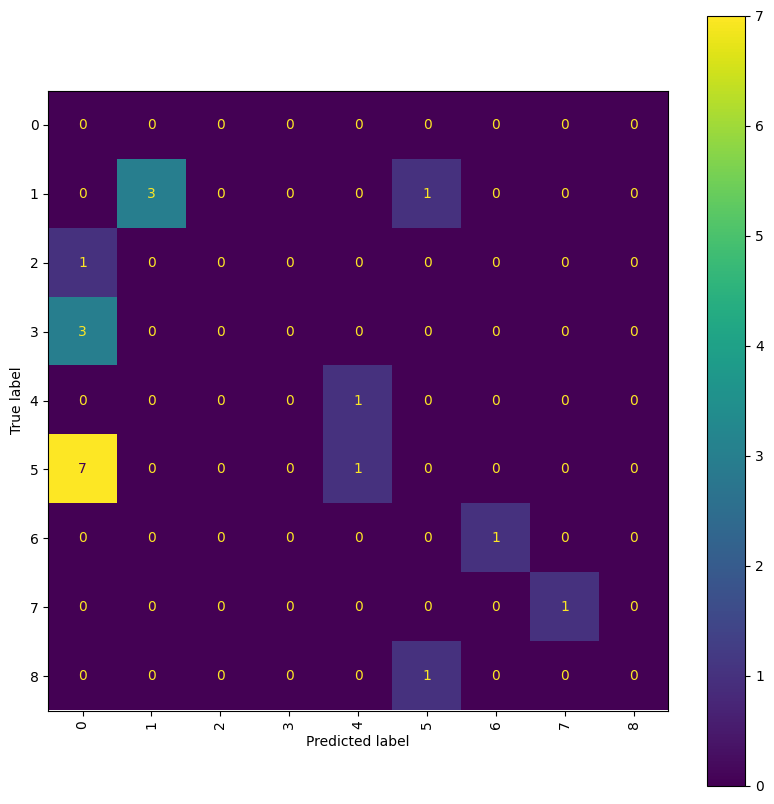

In [67]:
eval_classification(df_evaluate_reasons, 'ground_truth', 'pred')